In [1]:
"""
Ce script permet de tracer l'orographie du modèle AROME sur le Maroc 
ou une partie du domaine ainsi que les stations du réseau synoptique
à partir d'un fichier de données ASCII sous le format : 
    Latitude - Longitude - Valeur du champ

Finalité : Tracer tout autre champ spatialement sur le Maroc

Mme Feddoul    Rhizlane    :  11/03/2022  Version originale
Mr  Lemkhenter Abderrazak  :  01/04/2022  Amélioration du script 

N.B.: En cas de conflit de packages, supprimer SVP le package 
Il est à noter que ce script a été testé sous python 3.6
"""
import pandas as pd
import numpy as np
import geopandas
from shapely.ops import unary_union
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [2]:
"""
1- Lecture des données : Elevation/Mask
"""  
data = np.loadtxt('INDTERREMER-ALT-AROME.dat')
Long = data[:,0]; Lat = data[:,1]; Elev = data[:,3]; Mask= data[:,2]
df  = pd.DataFrame({'X':Long, 'Y':Lat, 'Z':Elev})
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.X, df.Y), crs='epsg:4326')
#
# 
X=gdf.X.array.reshape(661, 691)
Y=gdf.Y.array.reshape(661, 691)
Z=gdf.Z.array.reshape(661, 691)

In [3]:
"""
2- Lecture du shapeFile
(pour limiter le domaine de visualisation).
J'ai testé avec le shapefile regions/maroc (existant dans le même répertoire), mais ça n'a pas marché.
"""
shapefile = 'regions/regions.shp'
geodf = geopandas.read_file(shapefile)

"""
Union des polygones pour avoir le Maroc comme un seul polygone pour pouvoir tracer le contour.
"""
polys=[]
for g in geodf.geometry:
    polys.append(g)
maroc = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(unary_union(polys)), crs="EPSG:4326")

In [4]:
"""
3- Lecture du fichier du réseau des stations
"""
stations = pd.read_csv('DGM-Network.csv')
spoints = geopandas.GeoDataFrame(
        stations, geometry=geopandas.points_from_xy(stations.LON, stations.LAT), crs='epsg:4326')

In [5]:
def getRegionByNum(numRegion):
    """
    Region list by numRegion :
    ------------------------------
    0            RABAT-SALÉ-ZEMMOUR-ZAER        FRE    RÉGION          N   
    1               RÉGION DE L'ORIENTAL        FRE    RÉGION          N   
    2              OUED EDDAHAB-LAGOUIRA        FRE    RÉGION          N   
    3                       FÈS-BOULMANE        FRE    RÉGION          N   
    4                  CHAOUIA OUARDIGHA        FRE    RÉGION          N   
    5         MARRAKECH-TENSIFT-EL HAOUZ        FRE    RÉGION          N   
    6                       TADLA-AZILAL        FRE    RÉGION          N   
    7           GHARB-CHRARDA-BÉNI HSSEN        FRE    RÉGION          N   
    8   LAÂYOUNE-BOUJDOUR-SAKIA EL HAMRA        FRE    RÉGION          N   
    9            TAZA-AL HOCEIMA-TOUNATE        FRE    RÉGION          N   
    10                  GRAND CASABLANCA        FRE    RÉGION          N   
    11                  MEKNÈS-TAFILALET        FRE    RÉGION          N   
    12                  SOUSS-MASSA-DRÂA        FRE    RÉGION          N   
    13                    TANGER-TÉTOUAN        FRE    RÉGION          N   
    14                 GUELMIM-ES-SEMARA        FRE    RÉGION          N   
    15                     DOUKKALA ABDA        FRE    RÉGION          N   
    """
    reg = geodf.iloc[numRegion]
    region = geopandas.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[reg.geometry])
    return reg['POLY_NM_TR'], region

In [6]:
def createPolyFromCoordinates(lat, lon):
    poly_geom = Polygon(zip(lon, lat))
    poly = geopandas.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[poly_geom])
    return poly

In [7]:
def createZoneToPlot(gmask=None, byPoly=True):
    if gmask is not None:
        if byPoly:
            dzone = maroc.clip(gmask)
        else:
            dzone = gmask
        points = spoints.clip(dzone)
    else :
        dzone  = maroc
        points = spoints  
    #
    return dzone, points

In [8]:
def plotUsingShapeIntersection(fig, ax, gdf, dzone=maroc, points=None, withIsolines=False, 
                                scatterSize=10, marker='s', title=''):
    #
    res = gdf.clip(dzone)
    if res is None:
        return
    #
    cs = ax.scatter(res.X, res.Y, scatterSize, res.Z, cmap='gist_gray_r')
        
    if points is not None:
        points.plot(ax=ax, color='black', markersize=20, marker=marker);
    dzone.boundary.plot(ax=ax, color='k' )
    #
    ax.set_title(title+'\nElevation (m)', fontsize=25)
    ax.set_xlabel('Longitudes (°)', fontsize=20)
    ax.set_ylabel('Latitudes (°)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    cbar = fig.colorbar(cs, fraction=0.1, pad=0.01)
    cbar.ax.tick_params(labelsize=15)
    

In [84]:
def plotUsingRectangularMask(fig, ax, X, Y, Z, dzone=maroc, points=None, 
                withIsolines=False, 
                scatterSize=10, marker='s', 
                title='', titleFontSize=25, 
                labelSize=10):
    #
    [minx, miny, maxx, maxy]=dzone.total_bounds
    margex = abs(maxx - minx)/20.
    margey = abs(maxy - miny)/20.
    minx -= margex
    miny -= margey
    maxx += margex
    maxy += margey
    #
    plt.xlim([minx, maxx])
    plt.ylim([miny, maxy])
    #
    # Create rectangular mask by difference between polygon and dzone
    lat_point_list = [miny, maxy, maxy, miny, miny]
    lon_point_list = [minx, minx, maxx, maxx, minx]
    poly = createPolyFromCoordinates(lat_point_list, lon_point_list)
    mask = poly.difference(dzone)

    # Contour levels : 0, 50, 100, ... , 4000 
    levels = range(0, 4000, 50)
    cs = ax.contourf(X, Y, Z, levels=levels, cmap='gist_gray_r', zorder=3)
    if withIsolines:
        ax.contour(X, Y, Z,   cmap='gist_gray_r', zorder=4)
  
    if points is not None:
        points.plot(ax=ax, color='black', markersize=20, marker=marker, zorder=3 );
    #
    mask.plot(ax=ax, color='w', zorder=5)
    #
    dzone.boundary.plot(ax=ax, color='k', zorder=4 )
    #mask.boundary.plot(ax=ax, color='k', zorder=4 )
    #
    ax.set_title(title+'\nElevation (m)', fontsize=titleFontSize)
    ax.set_xlabel('Longitudes (°)', fontsize=labelSize)
    ax.set_ylabel('Latitudes (°)', fontsize=labelSize)
    ax.tick_params(axis='both', which='major', labelsize=labelSize)
    cbar = fig.colorbar(cs, ax=ax, fraction=0.05, pad=0.01)
    cbar.ax.tick_params(labelsize=labelSize)
    

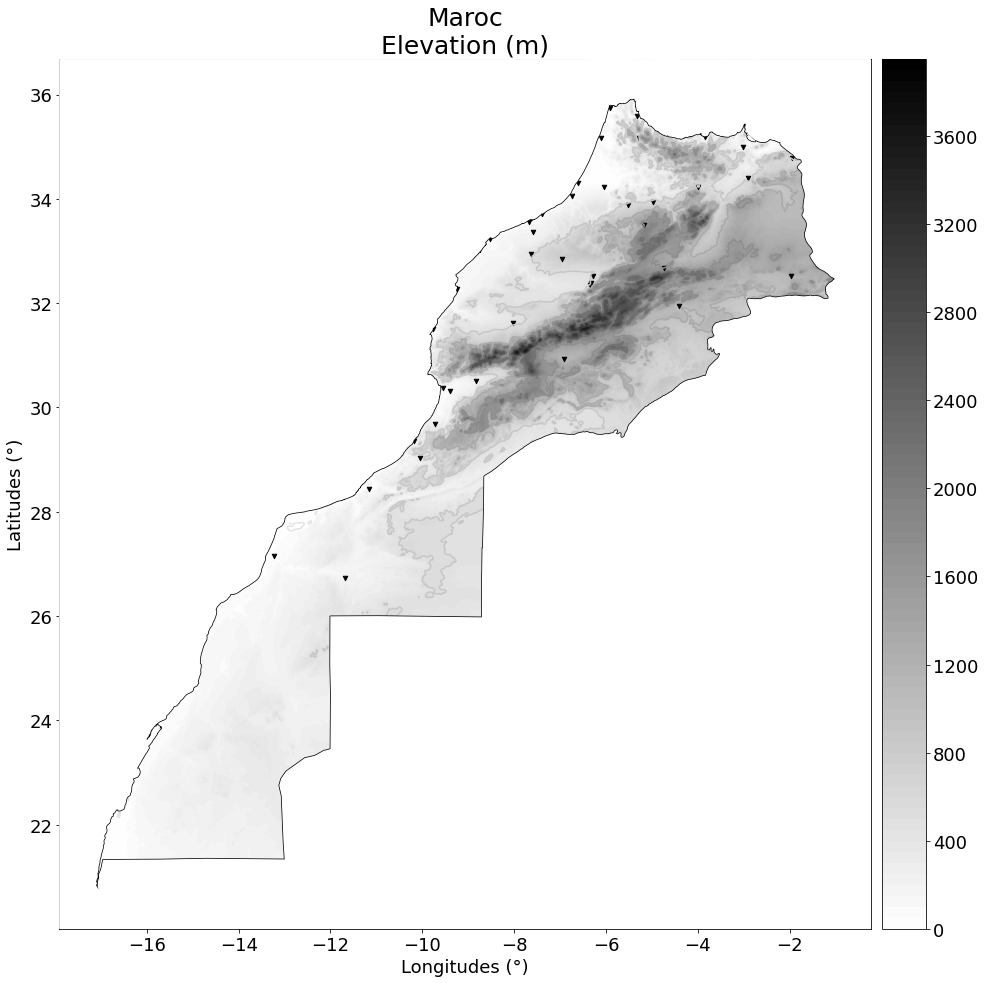

In [85]:
# Example 1 : Morocco
fig, ax = plt.subplots(1, 1, figsize=(20,16))
plotUsingRectangularMask(fig, ax, X,Y,Z, title="Maroc", points=spoints, withIsolines=True, marker="v", 
                         labelSize=18)


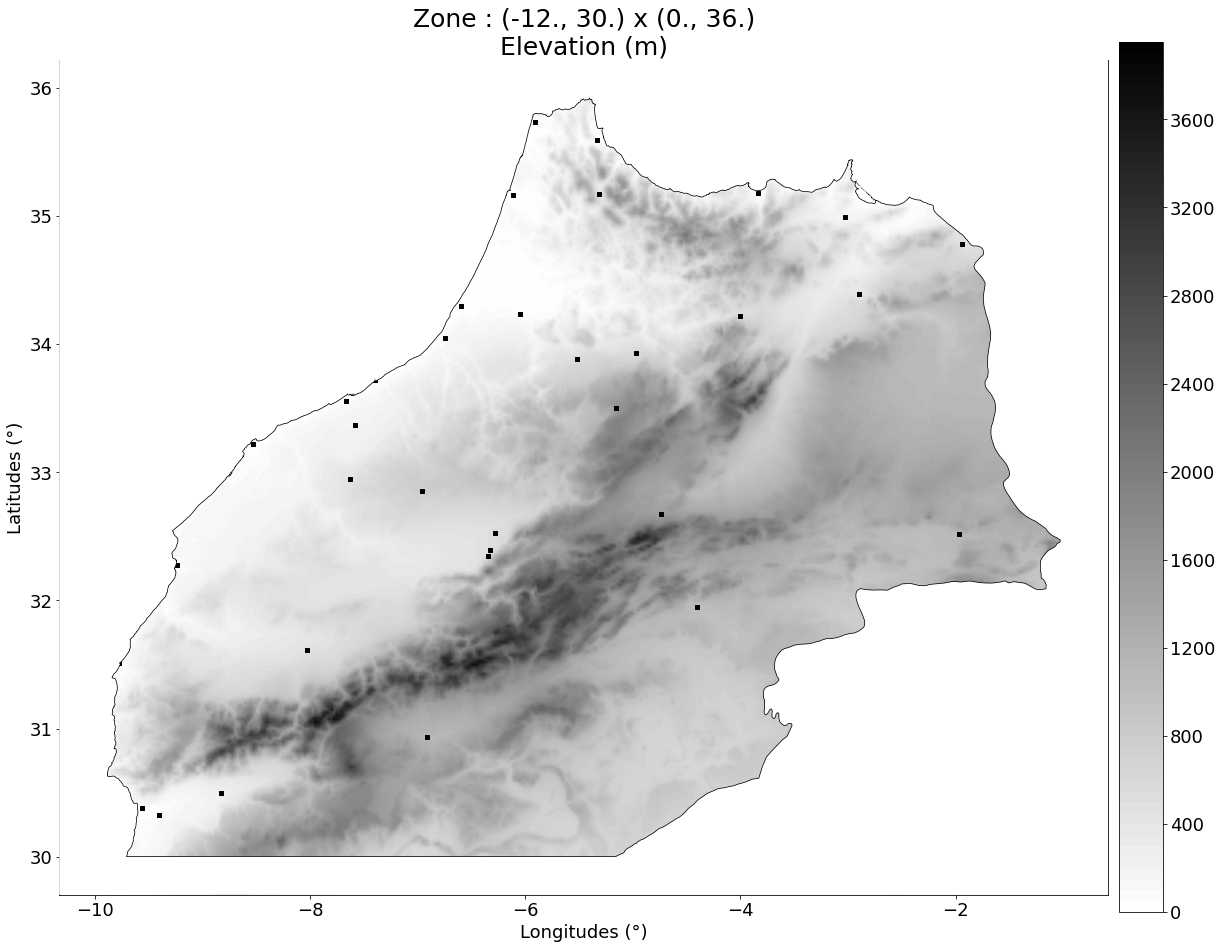

In [77]:
# Example 2- Zone defined by Polygon on Morocco 
fig, ax = plt.subplots(1, 1, figsize=(20,16))
lat_point_list = [30., 36., 36., 30., 30.]
lon_point_list = [-12., -12., 0., 0., -12.]
poly = createPolyFromCoordinates(lat_point_list, lon_point_list)
dzone1, points1 = createZoneToPlot(gmask=poly, byPoly=True)

plotUsingRectangularMask(fig, ax, X,Y,Z, dzone=dzone1, points=points1,
                         title="Zone : (-12., 30.) x (0., 36.)", labelSize=18)
plt.show()

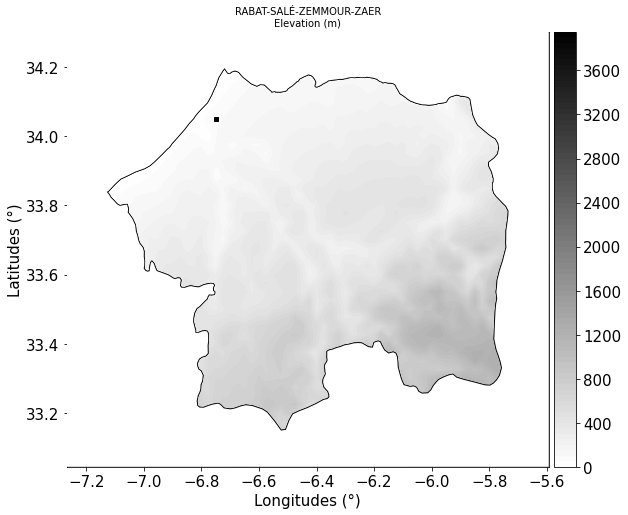

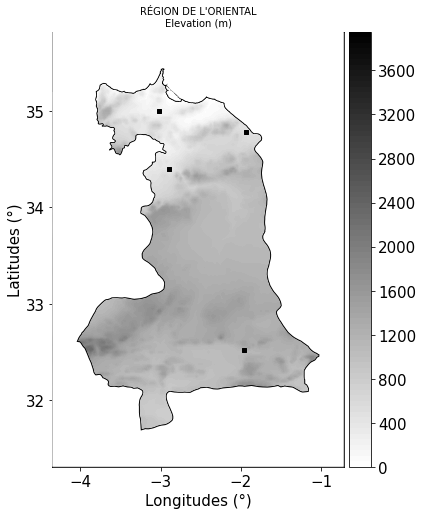

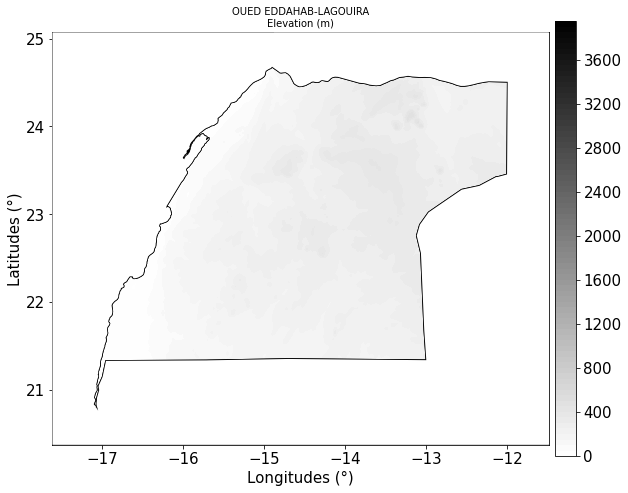

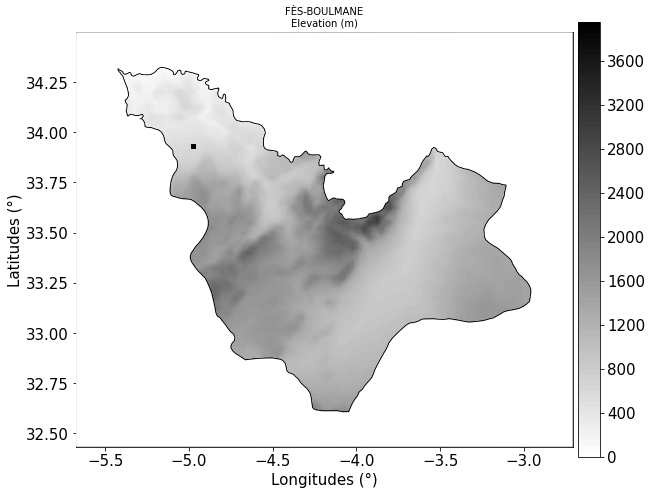

In [70]:
# Example 3- Region
"""
Liste des régions par numéro (extrait du shapefile) :
------------------------------
0            RABAT-SALÉ-ZEMMOUR-ZAER        FRE    RÉGION          N   
1               RÉGION DE L'ORIENTAL        FRE    RÉGION          N   
2              OUED EDDAHAB-LAGOUIRA        FRE    RÉGION          N   
3                       FÈS-BOULMANE        FRE    RÉGION          N   
4                  CHAOUIA OUARDIGHA        FRE    RÉGION          N   
5         MARRAKECH-TENSIFT-EL HAOUZ        FRE    RÉGION          N   
6                       TADLA-AZILAL        FRE    RÉGION          N   
7           GHARB-CHRARDA-BÉNI HSSEN        FRE    RÉGION          N   
8   LAÂYOUNE-BOUJDOUR-SAKIA EL HAMRA        FRE    RÉGION          N   
9            TAZA-AL HOCEIMA-TOUNATE        FRE    RÉGION          N   
10                  GRAND CASABLANCA        FRE    RÉGION          N   
11                  MEKNÈS-TAFILALET        FRE    RÉGION          N   
12                  SOUSS-MASSA-DRÂA        FRE    RÉGION          N   
13                    TANGER-TÉTOUAN        FRE    RÉGION          N   
14                 GUELMIM-ES-SEMARA        FRE    RÉGION          N   
15                     DOUKKALA ABDA        FRE    RÉGION          N   
"""
for reg in range(4):
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    name, region  = getRegionByNum(reg)
    dzone, points = createZoneToPlot(gmask=region, byPoly=False)
    plotUsingRectangularMask(fig, ax, X,Y,Z, dzone=dzone, points=points, scatterSize=25, 
                             title=name, titleFontSize=10, labelSize=15)
    plt.show()